In [2]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg

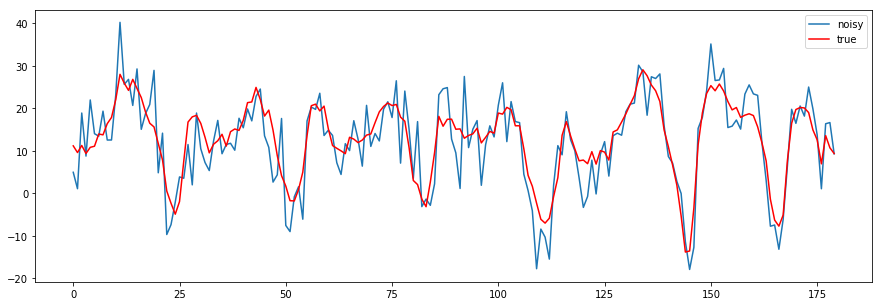

In [3]:
np.random.seed(1)
n_hidden = 140; seq_length = 300; training_size = 300
h = np.zeros((training_size, seq_length + 1, n_hidden)); 
# h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(20), size=100)
h[:, 0, :] = np.zeros((training_size, n_hidden))
y = np.zeros((training_size, seq_length + 1, 1)); y[:, 0] = np.zeros((training_size, 1))
sigma_c = 5.3
sigma_b = 1.

A = 0.8 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.2 * np.random.randn(1, n_hidden)
b = 1 * np.random.randn(n_hidden, 1)
c = 1 * np.random.randn(n_hidden, 1)
bias_h = np.random.rand(1, n_hidden)

for i in range(1, seq_length + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i-1, :], R) + np.dot(y[:, i-1], B)) + 0.7 * h[:, i-1, :] + bias_h
    y[:, i] = 1 * np.dot(h[:, i, :], b) + np.tanh(np.dot(h[:, i, :], c)) - 1 + sigma_b * np.random.randn(training_size, 1)

y = y[:, 1:]
fig, ax = plt.subplots(1,1,figsize=(15, 5))
y_tilde = (y + sigma_c * np.random.randn(training_size, seq_length, 1))
plt.plot(y_tilde[0, 20:200], label='noisy');
plt.plot(y[0, 20:200], 'r', label='true');
plt.legend();

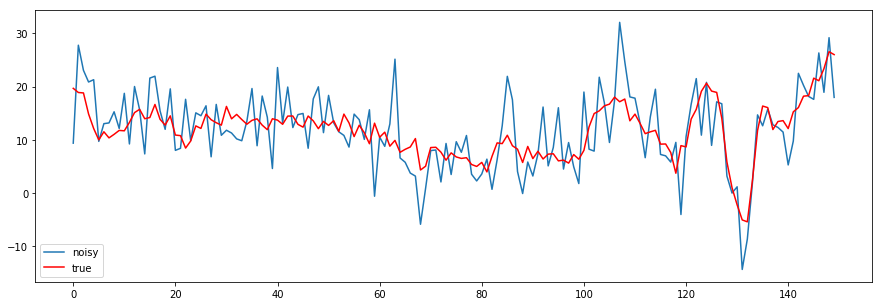

In [4]:
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[idx, 50:200], label='noisy');
plt.plot(y[idx, 50:200], 'r', label='true');
plt.legend();

In [5]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [6]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        self._std = std[None, None]

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        n_samples = mean.shape[0]
        return (mean, tf.tile(self._std, (n_samples, self._event_size))), state
    
class SamplingCellWithInputs(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCellWithInputs, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, inputs , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(tf.concat([sample, inputs], 1), state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, sample), (state, sample)
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, sample), (state, sample)

In [7]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        self._Z = 20                                              # Z
        
        self._gen_std = tf.nn.softplus(tf.get_variable('generative_std', shape=(),
                                         initializer=tf.constant_initializer(2))) + 1e-5
        
        self._trans_std = tf.nn.softplus(tf.get_variable('transitional_std', shape=(),
                                         initializer=tf.constant_initializer(5))) + 1e-5
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        self.q_z = self.make_posterior_z
        self.p_y = self.make_transitional
        self.compute_elbo
        self.optimise
        
        self.make_forward_posterior
        self.make_forward_parameters
        self.compute_elbo_forward
        self.forward_E_step
        self.forward_M_step
    
    @define_scope
    def make_posterior_z(self):
        self._post_cell_z = tfn.GRUBlockCell(self._H)
        _, h = tf.nn.dynamic_rnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, scale_diag=stds, validate_args=True, allow_nan_stats=False)
        return posterior_z
    
    @define_scope
    def make_kl_z(self):
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))
    
    @define_scope
    def make_transitional(self):
        self._code_z = self.q_z.sample((self._Sz))
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D, self._trans_std)
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        hidden = tf.layers.dense(tf.reshape(self._code_z, [-1, self._Z]), self._H, tf.nn.relu)      # (Sz * B) x Z
        state_and_sample = (hidden, tf.zeros((self._B * self._Sz, self._D)))
        inputs = tf.zeros((self._B * self._Sz, self._T, self._D))
        (means, self._code_y), _ = tf.nn.dynamic_rnn(self._sampling_cell, 
                                                     initial_state=state_and_sample, inputs=inputs)
        means = tf.identity(means, name='means')
        return tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._trans_std)
    
    @define_scope
    def make_reconstruction(self):
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, scale_identity_multiplier=self._gen_std,
                                              validate_args=True, allow_nan_stats=False)
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        return tf.reduce_sum(gen_prob.log_prob(data))/self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl_z = self.make_kl_z
        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z
        
        return loss, kl_z, reconstruction

    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))
    
    @define_scope
    def make_forward_posterior(self):
        y_mu = tf.get_variable(shape=(self._D), name='forward_y_mean', initializer=tf.constant_initializer(0))
        y_sigma = tf.nn.softplus(tf.get_variable(shape=(), initializer=tf.constant_initializer(2), 
                                                 name='forward_y_std'))
        return tfd.MultivariateNormalDiag(y_mu, scale_identity_multiplier=y_sigma)

    @define_scope
    def make_forward_parameters(self):
        return tf.get_variable(shape=(30, self._D), name='best_forward_sequence', 
                               initializer=tf.constant_initializer(0))
    
    @define_scope
    def compute_forward_message(self):
        h = self.make_posterior_z.sample((self._Sz))[:, 0, :]                        # Sz x Z
        h = tf.tile(self._layer2(self._layer1(h))[:, None, ...], (1, self._Sy, 1))   # Sz x Sy x H
        h = tf.reshape(h, [-1, self._H])                                             # (Sz * Sy) x H
        code = self._code_y                                                          # Sy x B x T x D
        code = tf.tile(code[None, :, 0], (self._Sz, 1, 1, 1))                        # Sz x Sy x T x D
        code = tf.reshape(code, [-1, self._T, self._D])                              # (Sz * Sy) x T x D
        code = tf.concat(tf.zeros(self._Sz * self._Sy, 1, self._D), code[:, 1:])
        for t in range(self._T):
            _, h = self._cell(code[:, t], h)
            h = tf.tile(tf.reduce_mean(h, 0, keep_dims=True), [self._Sz, 1])
        
        dist_y = tfd.Normal(self.make_posterior.mean()[-1, 0], self._post_std)
        return dist_y, h
    
    @define_scope
    def make_rnn_forward(self):
        _, hT = self.compute_forward_message
        hT = tf.tile(tf.reduce_mean(hT, 0, keep_dims=True), [self._S, 1])
        fake_inputs = tf.zeros((self._S, 50, 1))
        post_samples = self.make_forward_posterior.sample((self._S))
        (means, stddevs), _ = tf.nn.dynamic_rnn(self._sampling_cell, inputs=fake_inputs, 
                                                initial_state=(hT, post_samples[..., None]))
        return means, stddevs
    
    @define_scope
    def make_forward_kl_y(self):
        return tfd.kl_divergence(self.make_forward_posterior, self.compute_forward_message[0])
    
    def make_forward_reconstruction(self):
        return tfd.
    @define_scope
    def compute_elbo_forward(self):
        self._sampling_cell = SamplingCell(self._gauss_cell, 1, self._Sy)
        
        post = self.make_forward_posterior
        post_samples = post.sample((self._S))
        entropy = tf.log(tf.square(post.scale))
        
        dist_y, _ = self.compute_forward_message
        means, stddevs = self.make_rnn_forward
        
        pred = self.make_forward_parameters
        reconstruction_exp = tf.square(pred[None, :] - means[..., 0])/tf.square(stddevs[..., 0])
        reconstruction_norm = tf.reduce_sum(tf.reduce_mean(tf.log(tf.square(stddevs)), 0))
        reconstruction = - tf.reduce_mean(tf.reduce_sum(reconstruction_exp, -1)) - reconstruction_norm
        
        cross = tf.square(dist_y.mean() - post_samples)/tf.square(dist_y.scale)
        kl = - entropy + tf.reduce_mean(cross) + tf.log(tf.square(dist_y.scale))
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def forward_E_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)
    
    @define_scope
    def forward_M_step(self):
        post_var = [v for v in tf.trainable_variables() if 'make_forward_parameters' in v.name]
        return self._optimiser.minimize(-self.compute_elbo_forward[0], var_list=post_var)

In [8]:
tf.reset_default_graph()

seq_length = 50; n_samples = 1000; batch_size = 20;
data = y_tilde[:, 50:50+seq_length]
x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=30, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

elbos = []; kls_z = []; llks = []; stds = []; gen_stddevs = [];

for i in range(50000):
    idx = np.random.randint(0, training_size, batch_size)
    batch = data[idx, ...]
    
    elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)
    
    stds.append(sess.run(gen_model._trans_std, {x_: batch}))
    gen_stddevs.append(sess.run(gen_model._gen_std, {x_: batch}))
        
    if i % 5000 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk)
        
    sess.run(gen_model.optimise, {x_: batch})

Iteration: 0 ELBO: -46861.01 KL (z): 383.26056 Reconstruction: -46477.75


KeyboardInterrupt: 

In [ ]:
# tf.train.Saver().save(sess, '/Users/robertofiermonte/Repository/model_{}.ckpt'.format(batch_size))
for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch})
    sess.run(gen_model.forward_E_step, {x_: batch})
    sess.run(gen_model.forward_M_step, {x_: batch})
    
    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

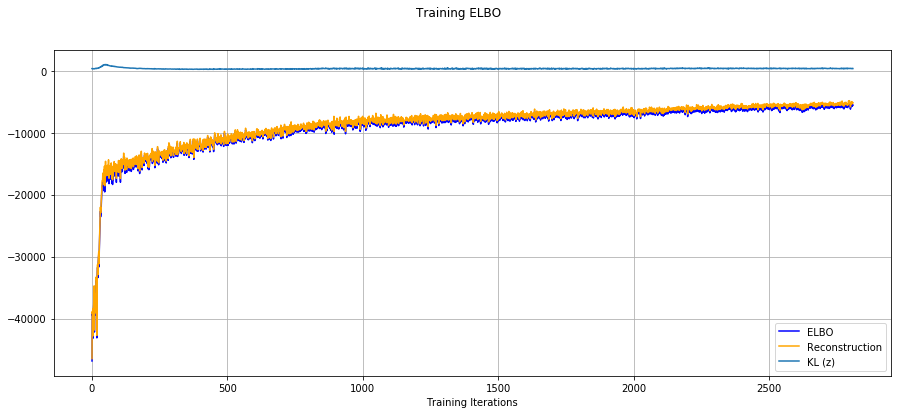

In [9]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (z)')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

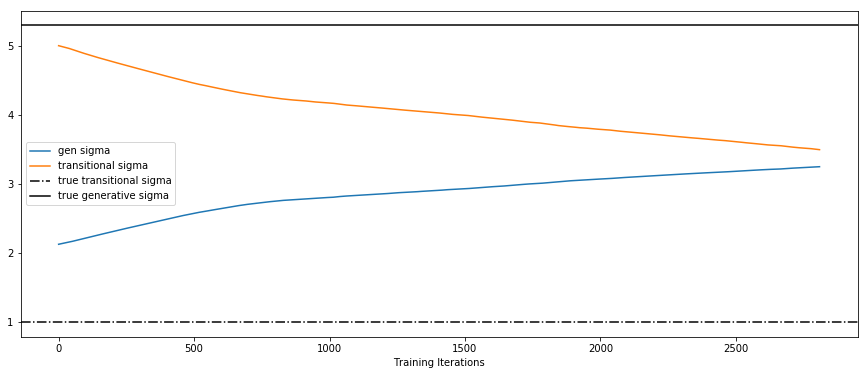

In [11]:
# 
trans_means_op = tf.get_default_graph().get_tensor_by_name('make_transitional/means:0')
means = sess.run(trans_means_op, {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})
#     
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.mean(s) for s in stds], label='transitional sigma')
plt.axhline(sigma_b, color='k', linestyle='-.', label='true transitional sigma')
plt.axhline(sigma_c, color='k', label='true generative sigma')
ax.set_xlabel('Training Iterations')
plt.legend();

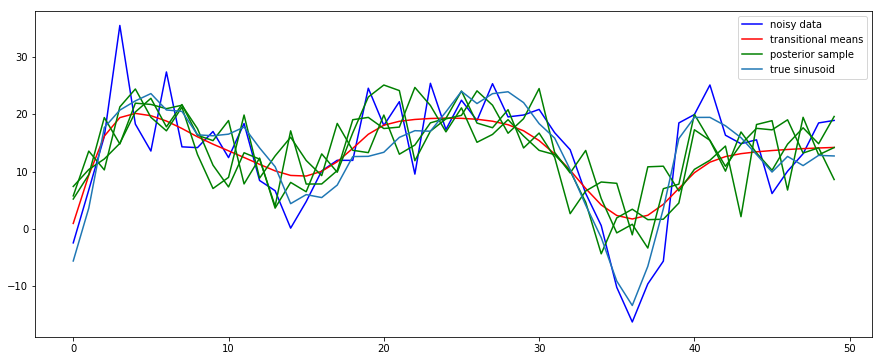

In [16]:
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='noisy data')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='transitional means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='posterior sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot(y[idx[i], 50:50+seq_length], label='true sinusoid')
plt.legend();

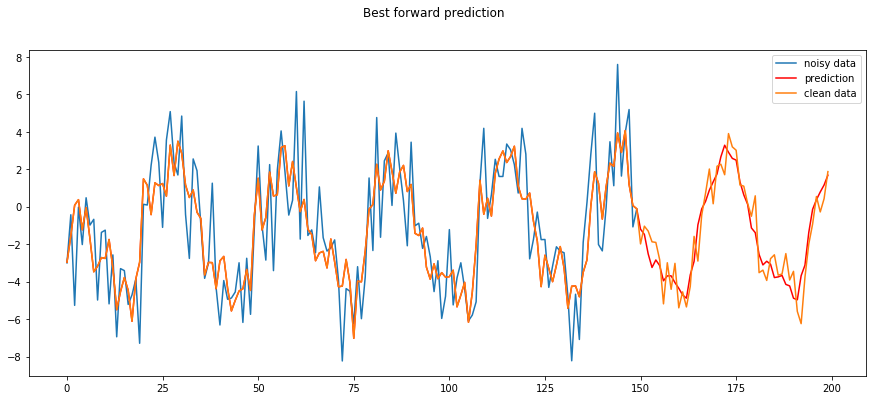

In [57]:
# Best forward pred at 10000 iters
code = sess.run(gen_model.make_forward_parameters, {x_: batch})
fig, axs = plt.subplots(1,1,figsize=(15, 6))
plt.plot(y_tilde[0, :seq_length], label='noisy data')
plt.plot(np.concatenate([y[0, :seq_length, 0], code], 0), 'r', label='prediction')
plt.plot(y[0, :seq_length+50], label='clean data')
plt.legend()
plt.suptitle("Best forward prediction");